# Introduction

### Lab 6.b: Retrieval Augmented Generation (RAG) using a labelled Q&A datasetRetrieval Augmented Generation (RAG) is a versatile pattern that can unlock a number of use cases requiring factual recall of information, such as querying a knowledge base in natural language.

In its simplest form, RAG requires these steps:

1. Extract knowledge base passages from documents (once)
2. Create vector embedding representations of each passage in the knowledge base
3. Retreive question from end user and generate vector embedding for it.
4. Retrieve relevant passage(s) from knowledge base (for every user query) using vector similarity search
5. Generate a response by feeding retrieved passage into a large language model (for every user query)

You will work through each of these steps in the following notebook.

<p align="center">
  <img src="images/rag-architecture-basic.png" width="600"/>
</p>

### Embeddings and Vector Databases
The current state-of-the-art in RAG is to create dense vector representations of the knowledge base in order to calculate the semantic similarity to a given user query.

We can generate dense vector representations using embedding models. In this notebook, we use [SentenceTransformers](https://www.google.com/search?client=safari&rls=en&q=sentencetransformers&ie=UTF-8&oe=UTF-8) [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) to embed both the knowledge base passages and user queries. `all-MiniLM-L6-v2` is a performant open-source model that is small enough to run locally.

A vector database is optimized for dense vector indexing and retrieval. This notebook uses [Chroma](https://docs.trychroma.com), a user-friendly open-source vector database, licensed under Apache 2.0, which offers good speed and performance with the all-MiniLM-L6-v2 embedding model.

To generate the final response to a query based on the retrieved passage, we leverage an open-source model, [Flan-UL2 (20B)](https://huggingface.co/google/flan-ul2), and include a prompt

### About the example dataset
The dataset used in this cookbook is a subset of [nq_open](https://huggingface.co/datasets/nq_open), an open-source question answering dataset based on contents from Wikipedia. The selected subset includes the gold standard passages to answer the queries in the dataset, which enables evaluating the retrieval quality.

You can select one of the two dataset available:
1. **nq910** - an information retrieval (a.k.a. search) data set extracted from Google's Natural Questions dataset.
2. **LongNQ** - an end-to-end retrieval and answer dataset extracted from the same NQ dataset, but focused more on abstractive, longer-form question answering. The answers were modified for fluency by IBM Research.

These datasets are available in the [data](data) folder.

### Limitations
Given that we are leveraging a locally-hosted embedding model, data ingestion and querying speeds can be slow.

### Cookbook Structure
1. Set-up dependencies
2. Index knowledge base <br>
3. Generate a retrieval-augmented response <br>
4. Evaluate RAG performance on your data <br>

# Disclaimer
**The IBM GenAI Python library used in this notebook is currently in Beta and will change in the future.**

# 1. Set-up dependencies

### 1.1 Install the required dependencies

Note that `ibm-generative-ai` requires `python>=3.9`. Ensure these pre-requisites are met before using this notebook

### 1.2. Import necessary modules

In [1]:
import os
import requests
import chromadb
import pandas as pd
from typing import Optional, Any, Iterable, List

from dotenv import load_dotenv

try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    raise ImportError("Could not import sentence_transformers: Please install sentence-transformers package.")
    
try:
    import chromadb
    from chromadb.api.types import EmbeddingFunction
except ImportError:
    raise ImportError("Could not import chromdb: Please install chromadb package.")
    
from genai.model import Credentials
from genai.schemas import GenerateParams
from genai import PromptPattern, Model
from typing import Dict, Optional, List
from rouge import Rouge

### 1.3. Load credentials for `ibm-generative-ai`

Your `.env` file needs to have the following lines without spaces around `=`. Set its path correctly in the below `get_genai_creds()` function.

```
GENAI_KEY=<your-genai-key>
GENAI_API=<your-genai-api>
```

By default, `IBM-Generative-AI` will automatically use the following API endpoint: https://workbench-api.res.ibm.com/v1/. However, if you wish to target a different Gen AI API, you can do so by providing a custom API endpoint. 

In [183]:
def get_genai_creds():
    load_dotenv(".env")
    api_key = os.getenv("GENAI_KEY", None)
    api_url = os.getenv("GENAI_API", None)
    if api_key is None or api_url is None:
        print("Either api_key or api_url is None. Please make sure your credentials are correct.")
    creds = Credentials(api_key, api_url)
    return creds

creds = get_genai_creds()

# 2. Index knowledge base

### 2.1. Load data

Select one of the two dataset available:
1. *nq910* - an Information Retrieval (a.k.a. search) data set extracted from Google's Natural Questions dataset.
2. *LongNQ* - an end-to-end retrieval and answer dataset extracted from the same NQ dataset, but focused more on abstractive question answering.

These datasets are provided under the /data directory.

In [185]:
datasets = ['LongNQ', 'nq910']
dataset = datasets[0]    # The current dataset to use
data_root = "data"
data_dir = os.path.join(data_root, dataset)
max_docs = -1
print("Selected dataset:", dataset)

Selected dataset: LongNQ


In [187]:
def load_data_v1(data_dir, data_root):
    passages = pd.read_csv(os.path.join(data_dir, "passages.tsv"), sep='\t', header=0)
    qas = pd.read_csv(os.path.join(data_dir, "questions.tsv"), sep='\t', header=0).rename(columns={"text": "question"})
    
    # We only use 5000 examples.  Comment the lines below to use the full dataset.
    passages = passages.head(5000)
    qas = qas.head(5000)
    
    return passages, qas
documents, questions = load_data_v1(data_dir, data_root)
documents['indextext'] = documents['title'].astype(str) + "\n" + documents['text']

The dataset we are using is already split into self-contained passages that can be ingested by Chroma. 

The size of each passage is limited by the embedding model's context window (which is 256 tokens for `all-MiniLM-L6-v2`). 

In case your dataset requires splitting, it is recommended to split according to the document's structure and include contextual metadata such as a title for each passage. You may need to include a stride window for lengthier passages if there is a risk of cutting off important context.
There is usually some experimentation required to get splitting right. It's helpful to have a test dataset to evaluate the impact of passage splitting on the retrieval quality (see section 4.1.).

### 1.2. Create an embedding function

Note that you can feed a custom embedding function to be used by chromadb. The performance of chromadb may differ depending on the embedding model used.

In [188]:
class MiniLML6V2EmbeddingFunction(EmbeddingFunction):
    MODEL = SentenceTransformer('all-MiniLM-L6-v2')
    def __call__(self, texts):
        return MiniLML6V2EmbeddingFunction.MODEL.encode(texts).tolist()
emb_func = MiniLML6V2EmbeddingFunction()

### 2.3. Set up Chroma upsert

Upserting a document means update the document even if it exists in the database. Otherwise re-inserting a document throws an error. This is useful for experimentation purpose.

In [189]:

class ChromaWithUpsert:
    def __init__(self, name,persist_directory, embedding_function,collection_metadata: Optional[Dict] = None,
    ):
        self._client = chromadb.PersistentClient(path=persist_directory)
        self._embedding_function = embedding_function
        self._persist_directory = persist_directory
        self._name = name
        self._collection = self._client.get_or_create_collection(
            name=self._name,
            embedding_function=self._embedding_function
            if self._embedding_function is not None
            else None,
            metadata=collection_metadata,
        )

    def upsert_texts(
        self,
        texts: Iterable[str],
        metadata: Optional[List[dict]] = None,
        ids: Optional[List[str]] = None,
        **kwargs: Any,
    ) -> List[str]:
        """Run more texts through the embeddings and add to the vectorstore.
        Args:
            :param texts (Iterable[str]): Texts to add to the vectorstore.
            :param metadatas (Optional[List[dict]], optional): Optional list of metadatas.
            :param ids (Optional[List[str]], optional): Optional list of IDs.
            :param metadata: Optional[List[dict]] - optional metadata (such as title, etc.)
        Returns:
            List[str]: List of IDs of the added texts.
        """
        # TODO: Handle the case where the user doesn't provide ids on the Collection
        if ids is None:
            import uuid
            ids = [str(uuid.uuid1()) for _ in texts]
        embeddings = None
        self._collection.upsert(
            metadatas=metadata, documents=texts, ids=ids
        )
        return ids

    def is_empty(self):
        return self._collection.count()==0

    def query(self, query_texts:str, n_results:int=5):
        """
        Returns the closests vector to the question vector
        :param query_texts: the question
        :param n_results: number of results to generate
        :return: the closest result to the given question
        """
        return self._collection.query(query_texts=query_texts, n_results=n_results)

###  2.4 Embed and index documents with Chroma
You will now generate embeddings for the passages. This will take

However if you want to full experience, then delete these files and rebuild them yourself.  Note that creating the embeddings and indexes can take a long time.  E.g. on a 2021 Macbook Pro, it took 45 mins to generate these files for the LongNQ dataset.

In [ ]:
%%time
chroma = ChromaWithUpsert(
    name=f"{dataset}_minilm6v2",
    embedding_function=emb_func,  # you can have something here using /embed endpoint
    persist_directory=data_dir,
)
if chroma.is_empty():
    _ = chroma.upsert_texts(
        texts=documents.indextext.tolist(),
        # we handle tokenization, embedding, and indexing automatically. You can skip that and add your own embeddings as well
        metadata=[{'title': title, 'id': id}
                  for (title,id) in
                  zip(documents.title, documents.id)],  # filter on these!
        ids=[str(i) for i in documents.id],  # unique for each doc
    )

# 3. Generate a retrieval-augmented response to a question 

### 3.1. Instantiate `genai` model

In [175]:
params = GenerateParams(
    decoding_method="greedy",
    max_new_tokens=100,
    min_new_tokens=1,
    stream=False,
    temperature=0,
)
model = Model(model='google/flan-ul2', credentials=creds, params=params)

### 3.2. Select a question

In [176]:
question_index = 65
question_text = questions.question[question_index].strip("?") + "?"
print(question_text)

what is the tax rate for lottery winnings in california?


### 3.3. Retrieve relevant context
Send the question to Chroma which will convert the question into an embedding then run similarity search for the specified number of matching passages.  This process is VERY FAST!!

In [177]:
relevant_chunks = chroma.query(
    query_texts=[question_text],
    n_results=5,
)
for i, chunk in enumerate(relevant_chunks['documents'][0]):
    print("=========")
    print("Paragraph index : ", relevant_chunks['ids'][0][i])
    print("Paragraph : ", chunk)
    print("Distance : ", relevant_chunks['distances'][0][i])

Paragraph index :  4172
Paragraph :  California State Lottery
Assembly Member Van Tran 's Assembly Bill 1251 , modifying California Government Code section 8880.321 to allow for a one - year claim period for a Mega Millions jackpot prize . This is the only prize in California that has a one - year claim period . All other prizes have the 180 - day claim period . This legislation affected Mega Millions drawings after July 5 , 2008 . All prizes for Fantasy 5 , Daily Derby , Daily 3 , Daily 4 , and non-jackpot SuperLotto Plus , Mega Millions , and Powerball prizes , are paid out in one payment , less 25 % or 33 % ( depending upon the winner 's tax documentation ) Federal withholding if the prize is over $5,000 . Merchandise prizes over $5,000 are subject to 33 % Federal withholding . Scratchers tickets are generally one - payment prizes ; however , some games have annuity options for payments each year , or per week . California does not tax California Lottery winnings , however it taxes 

/Users/anthonystevens/miniconda3/envs/genai/lib/python3.11/site-packages/chromadb/utils/read_write_lock.py:29: DeprecationWarning: notifyAll() is deprecated, use notify_all() instead
  self._read_ready.notifyAll()


### 3.4. Feed the context and the question to `genai` model.

`make_prompt` is a function to create a prompt from the given context and question. Changing the prompt will sometimes result in much more appropriate answers (or it may degrade the quality significantly).

In [178]:
def make_prompt(context, question_text):
    return (f"{context}\n\nPlease answer a question using this "
          + f"text. "
          + f"If the question is unanswerable, say \"unanswerable\"."
          + f"Question: {question_text}")

In [179]:
context = "\n\n\n".join(relevant_chunks["documents"][0])
prompt = make_prompt(context, question_text)

Generate response

In [180]:
responses = model.generate([prompt])
response = responses[0]

In [181]:
print("Question = ", question_text)
print("Answer = ", response.generated_text)
print("Expected Answer(s) (may not be appear with exact wording in the dataset) = ", questions.answers[question_index])

Question =  what is the tax rate for lottery winnings in california?
Answer =  California does not tax California Lottery winnings
Expected Answer(s) (may not be appear with exact wording in the dataset) =  All prizes for Fantasy 5, Daily Derby, Daily 3, Daily 4, and non-jackpot SuperLotto Plus, Mega Millions, and Powerball prizes, are paid out in one payment, less 25 % or 33 % (depending upon the winner 's tax documentation) Federal Withholding if the prize is over $5,000. California does not tax California Lottery winnings, however it taxes lottery winnings from other jurisdictions.


## 4. Evaluate RAG performance on your data
Evaluating the performance of your Generative AI system is critical to ensuring happy end users.  However evaluation also requires having a test dataset.  In this case, the top passages that shoudl be return for each question.

Note that we want to evaluate the performance of both (1) the embedding function plus (2) how well the GenAI model summarizes the results.

So our test set must contain:
1. The indexes of the passage(s) that contain the answer - i.e. the goldstandard passages (if the question is answerable by the knowledge base)
2. The question's gold standard answer (this can be short or long-form)


### 4.1. Evaluate the retrieval quality
Were the correct passages returned via the similarity search functionality

There are many ways to compute retrieval quality, namely how the information contained in the documents that are relevant to the question being asked. We're focusing here on success at given number of returns  (aka recall at given levels), which is to say, given a fixed number of documents returned (e.g., 1, 3, 5), is the question's answer contained in them. The scores increase with the recall level.

In [28]:
def compute_score(questions, answers, ranks=[1, 3, 5, 10], use_rouge=False, rouge_threshold=0.7):
    """
    Computes the success at different levels of recall, given the goldstandard passage indexes per query.
    It computes two scores:
       * Success at rank_i, defined as sum_q 1_{top i answers for question q contains a goldstandard passage} / #questions
       * Lenient success at rank i, defined as
                sum_q 1_{ one in the documents in top i for question q contains a goldstandard answer) / #questions
    Note that a document that contains the actual textual answer does not necesarily answer the question, hence it's a
    more lenient evaluation. Any goldstandard passage will contain a goldstandard answer text, by definition.
    Args:
        :param questions: List[Dict['id': AnyStr, 'text': AnyStr, 'relevant': AnyStr, 'answers': AnyStr]]
           - the input queries. Each query is a dictionary with the keys 'id','text', 'relevant', 'answers'.
        :param input_passages: List[Dict['id': AnyStr, 'text': AnyStr', 'title': AnyStr]]
           - the input passages. These are used to create a reverse-index list for the passages (so we can get the
             text for a given passage ID)
        :param answers: List[List[AnyStr]]
           - the retrieved passages IDs for each query
        :param ranks: List[int]
           - the ranks at which to compute success
        :param use_rouge: Boolean
           - turns on the use of rouge as a scorer
        :param rouge_threshold: float, default=0.7
           - defines the minimum rouge-l/r score to accept the answer as a match,
    Returns:


    """
    # if "relevant" not in input_queries[0] or input_queries[0]['relevant'] is None:
    #     print("The input question file does not contain answers. Please fix that and restart.")
    #     sys.exit(12)
    #
    scores = {r: 0 for r in ranks}
    lscores = {r: 0 for r in ranks}

    gt = {}
    for q_relevant, q_qid in zip(questions.relevant, questions.qid):
        if isinstance(q_relevant, str):
            rel = [int(i) for i in q_relevant.split(",")]
        else:
            rel = [q_relevant]
        gt[q_qid] = rel

    def update_scores(ranks, rnk, scores):
        j = 0
        while j < len(ranks) and ranks[j] < rnk:
            j += 1
        for k in ranks[j:]:
            scores[k] += 1

    scorer = None
    if use_rouge:
        from rouge import Rouge
        scorer = Rouge()

    num_eval_questions = 0

    for qi, (qid, q_answers) in enumerate(zip(questions.qid, questions.answers)):
        tmp_scores = {r: 0 for r in ranks}

        text_answers = str(q_answers).split("::")
        if "-" in text_answers:
            # The question does not have answers, skip it for retrieval score purposes.
            continue
        num_eval_questions += 1
        # Compute scores based on the goldstandard annotation
        for ai, ans in enumerate(answers[qi]):
            if int(ans['id']) in gt[qid]:  # Great, we found a match.
                update_scores(ranks, ai + 1, tmp_scores)
                break

        # Compute score on approximate match - either answer inclusion in the text or
        # minimum rouge score alignment.
        tmp_lscores = tmp_scores.copy()  # making sure we're actually lenient
        #inputq = questions[qi]
        for ai, ans in enumerate(answers[qi]):
            txt = ans['text'].lower()
            found = False
            for text_answer in text_answers:
                if use_rouge:
                    score = scorer.get_scores(text_answer.lower(), txt)
                    if max(score[0]['rouge-l']['r'], score[0]['rouge-l']['p']) > rouge_threshold:
                        update_scores(ranks, ai + 1, tmp_lscores)
                        break
                else:
                    if not isinstance(text_answer, str):
                        print(f"Error on text_answer {text_answer}, question {qi}, answer {ai}-{ans}")
                    if txt.find(text_answer.lower()) >= 1:
                        update_scores(ranks, ai + 1, tmp_lscores)
                        break

        for r in ranks:
            scores[r] += int(tmp_scores[r] >= 1)
            lscores[r] += int(tmp_lscores[r] >= 1)

    res = {"num_ranked_queries": num_eval_questions,
           "num_judged_queries": num_eval_questions,
           "success":
               {r: int(1000 * scores[r] / num_eval_questions) / 1000.0 for r in ranks},
           "lenient_success":
               {r: int(1000 * lscores[r] / num_eval_questions) / 1000.0 for r in ranks},
           "counts": {r: scores[r] for r in ranks},
           'lcounts': {r: lscores[r] for r in ranks}
           }

    return res

### Compute the retrieval score over all the documents
Can take up to a minute

In [22]:
k = 5
retrieved_docs = []
for q in questions.question:
    answers = chroma.query(query_texts=q, n_results=k)

    retrieved_docs.append([{'id': id, 'text': text}
                           for (id, text) in zip(answers['ids'][0], answers['documents'][0])])

res = compute_score(questions, retrieved_docs,
                    ranks=[1, 3, 5], use_rouge=(data_dir == 'docs_and_qs'))
print(res)

{'num_ranked_queries': 300, 'num_judged_queries': 300, 'success': {1: 0.33, 3: 0.666, 5: 0.77}, 'lenient_success': {1: 0.336, 3: 0.673, 5: 0.776}, 'counts': {1: 99, 3: 200, 5: 231}, 'lcounts': {1: 101, 3: 202, 5: 233}}


In [27]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def plot(res):
    fig, ax = plt.subplots()
    scores = res['success'].values()
    keys = [f'R@{i}' for i in res['success'].keys()]
    x_pos = np.arange(len(keys))
    ax.bar(x_pos, scores, align='center', alpha=0.5)
    ax.set_ylabel('Success Rate')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(keys)
    ax.set_title('Success rates at different recall rates.')
    ax.yaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()
    plt.savefig('bar_plot.png')
    plt.show()

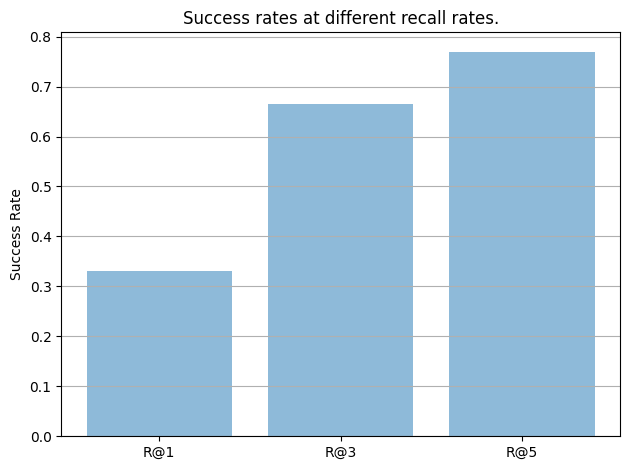

In [28]:
plot(res)

### 4.2. Evaluate quality of generated responses
I.e. how well did the GenAI model summarize and extract the correct answer to the user's question from the passages returned by the similarity function.  Obviously if the returned passages were invalid, then performance at this phase would suffer too.

Automatically evaluating the quality of answers is difficult, as many factors come into play, such as fluency, helpfulness, coverage, etc. One simplified way of computing this quality is using the ROUGE metric, in particular ROUGE-L. To compute this metric, for every answer returned for a question, we measure the maximum subsequence of words between the system answer and the gold-standard answer. Given this sequence, we can compute the precision of the given answer as the length (all lengths are in words) of this sequence divided by the length of the system answer and the recall as the length of the longest common subsequence divided by the length the gold-standard answer.
$$ P_{ROUGE-L} = \frac{|lcs(system,gold)|}{|system|} \\ R_{ROUGE_L} = \frac{|lcs(system,gold|}{|gold|} $$

where $lcs(system, gold)$ is the longest commong subsequence between $system$ and $gold$.

ROUGE was devised in the NLP community to evaluate summarization, and is commonly used to also evaluate abstractive question answering.

In [29]:
def score_answers(_answers, _reference, score_type="rouge-l", val="r", use_rouge=True):
    """
    Compute the score of a set of answers, given a set of references, using Rouge score.
    :param answers: Union[List[str], str]
       - the returned answer/answers.
    :param reference:
        - the reference answers, in a string. Answers are separated by ':::'
    :param use_rouge: Boolean
        - if true, then use rouge for scoring, otherwise use substring.
    :return:
       - The maximum rouge-L score of the cartesian product of answers/references
    """
    if isinstance(_answers, str):
        _answers = [_answers]
    _references = _reference.lower().split("::")
    max_score = -1
    scorer = Rouge()
    closest_ref = ""
    for ref in _references:
        for _answer in _answers:
            if use_rouge:
                scores = scorer.get_scores(_answer.lower(), ref)
                score = scores[0][score_type][val]
            else:
                score = int(ref.find(_answer.lower()) >= 0)
            if score > max_score:
                max_score = score
                closest_ref = ref

    return max_score, closest_ref

Compute the score for the previous example

In [30]:
print("Question = ", question_text)
print("Answer = ", response.generated_text)
score, closest_ref = score_answers(response.generated_text, questions.answers[question_index], val='r')
print(f"Closest reference: \"{closest_ref}\"")
print(f"Recall:\t\t{100*score:5.2f}%")
score, _ = score_answers(response.generated_text, questions.answers[question_index], val='p')
print(f"Precision:\t{100*score:5.2f}%")

Question =  what are the three stages of cell division?
Answer =  interphase , the mitotic ( M ) phase , and cytokinesis
Closest reference: "in bacteria, which lack a cell nucleus, the cell cycle is divided into the b, c, and d periods.   in cells with a nucleus, as in eukaryotes, the cell cycle is also divided into three periods: interphase, the mitotic phase, and cytokinesis."
Recall:		14.29%
Precision:	40.00%


#### Compute (Rouge-based) precision and recall for the entire collection.

It takes about 1-2 seconds per question. For a corpus of ~1000 questions, this take can take up to 30min.

In [31]:
def is_answerable(relevant):
    return "-1" in relevant

In [32]:
rscore = 0
pscore = 0
import tqdm
num_eval_questions = 50
eval_questions = questions[:num_eval_questions]
count = {"11": 0, "10": 0, "01": 0, "00": 0}
seq = []
for (question_text, answers, relevant) in tqdm.tqdm(zip(eval_questions.question, eval_questions.answers, eval_questions.relevant), total=len(eval_questions)):
    # ans = qa(question.question)
    relevant_chunks = chroma.query(
        query_texts=[question_text],
        n_results=5,
    )
    context = "\n\n\n".join(relevant_chunks["documents"][0])
    prompt = make_prompt(context, question_text)
    ans = model.generate([prompt])
    q_answerable = is_answerable(relevant)
    if ans[0].generated_text == "unanswerable":
        res = "10" if q_answerable else "00"
        count [res] += 1
        if not q_answerable:
            rscore += 1
            pscore += 1
    else:
        res = "11" if q_answerable else "10"
        count[res] += 1
        if q_answerable:
            qrscore, _ = score_answers(ans[0].generated_text, answers, val='r')
            rscore += qrscore
            qpscore, _ = score_answers(ans[0].generated_text, answers, val='p')
            pscore += qpscore
    seq.append(res)

100%|██████████| 50/50 [02:27<00:00,  2.96s/it]


In [33]:
from IPython.display import HTML, display
def displayHTMLTables(*tables):
    def htmlTable(table):
        return '<table border="2"><tr>{}</tr></table>'.format(
                    '</tr><tr>'.join(
                        '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in table)
                )

    display(HTML('<table><tr><td>{}</td></tr></table>'.format(
                "</td><td>".join(htmlTable(table) for table in tables))
))

In [38]:
res = [['', 'Overall', 'Answerable questions'],
       ['Precision', f"{100*pscore/len(eval_questions):5.2f}", f"{100*(pscore-count['00'])/(count['10']+count['11']):5.2f}"],
       ['Recall',    f'{100*pscore/len(eval_questions):5.2f}', f"{188*(rscore-count['00'])/(count['10']+count['11']):5.2f}"],
       ]
counts = [['Gold/System', 'No Answer', 'Answered'],
        ['No Answer', count["00"], count["01"]],
        ['With Answer', count["10"], count["11"]]]#%% md

displayHTMLTables(res, [], [], counts)

,Overall,Answerable questions
Precision,10.00,0.00
Recall,10.00,0.00
Gold/System,No Answer,Answered
No Answer,5,0
With Answer,44,1
